<font size ="+2"> 1 Introducción </font>

El siguiente ejemplo ilustra el comportamiento de un filtro de pase alto (High pass filter) que hace referencia a atenuar los componentes con una "frecuencia" baja, mientras que los componentes de alta frecuencia no se ven afectados.

(Esto es en el caso que trabajemos con un espectro de frecuencias, con respecto al trabajo con imágenes el filtro es aplicado a los píxeles de la imagen respectiva)

Con respecto a la imagen, su implementación es similar a pasar una imagen a escala de grises, pero solamente modificando aquellos píxeles que no superen cierto umbral. 



<font size ="+2"> 2 Armado del ambiente </font>

Toma la dirección web de una imagen con acceso público en internet, la deja disponible al contexto de ejecución del cuaderno colab.

In [83]:
#@title # 2.1 Parametros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen =  "https://github.com/SistemasOperativosAvanz/hpc-tp-3/blob/main/sampleImageGrayscale.jpg?raw=true" #@param {type:"string"}

#@markdown ---
#!wget https://resizer.glanacion.com/resizer/Wt7c9G_TCewfo1JU_YQh38ygBRY=/768x0/filters:quality(80)/cloudfront-us-east-1.images.arcpublishing.com/lanacionar/BPZX5263MZDBFNHZDVZ5BLP73Y.jpg -O imagen.jpg

!wget {url_imagen} -O imagen.jpg

--2021-11-22 23:18:00--  https://github.com/SistemasOperativosAvanz/hpc-tp-3/blob/main/sampleImageGrayscale.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/SistemasOperativosAvanz/hpc-tp-3/raw/main/sampleImageGrayscale.jpg [following]
--2021-11-22 23:18:00--  https://github.com/SistemasOperativosAvanz/hpc-tp-3/raw/main/sampleImageGrayscale.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SistemasOperativosAvanz/hpc-tp-3/main/sampleImageGrayscale.jpg [following]
--2021-11-22 23:18:00--  https://raw.githubusercontent.com/SistemasOperativosAvanz/hpc-tp-3/main/sampleImageGrayscale.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubuserco

<font size="+2"> 3 - Desarrollo CPU </font>

Código que resuelve el ejercicio desde el punto de vista secuencial. Partimos de la base de una imagen en escala de grises, que luego de aplicar el filtro, los píxeles que no sobrepasan el umbral son atenuados.

En este ejemplo, se genera una imagen con fftpack (Se lo pasa a un espectro de frecuencias, así es como se trabaja en electrónica este filtro), luego se le aplica el filtro de paso alto (High Pass Filter) y obtenemos la imagen correspondiente.

Tambien podríamos haber utilizado la siguiente matriz: 

              [-1, -1, -1]
              [-1,  8, -1]
              [-1, -1, -1]

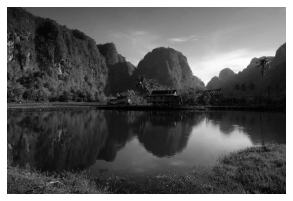

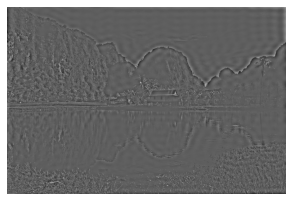

Tiempo CPU:  297.327 [ms]


In [84]:
from skimage.io import imread
import matplotlib.pyplot as plt
import scipy.fftpack as fp
import numpy as np

from datetime import datetime
tiempo_total = datetime.now()

# ----------------------------------------------------------
# Definición de función que transforma el tiempo en milisegundos
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# ----------------------------------------------------------

im = np.mean(imread('imagen.jpg'), axis=2) # assuming an RGB image
plt.figure(figsize=(5,5))
plt.imshow(im, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

F1 = fp.fft2((im).astype(float))
F2 = fp.fftshift(F1)

(w, h) = im.shape
half_w, half_h = int(w/2), int(h/2)

# high pass filter
n = 25
F2[half_w-n:half_w+n+1,half_h-n:half_h+n+1] = 0 # select all but the first 50x50 (low) frequencies

tiempo_total = datetime.now() - tiempo_total

im1 = fp.ifft2(fp.ifftshift(F2)).real
plt.figure(figsize=(5,5))
plt.imshow(im1, cmap='gray')
plt.axis('off')
plt.show()


print("Tiempo CPU: ", tiempo_en_ms(tiempo_total), "[ms]")




<font size = "+2"> 4.1 Instala en el cuaderno el módulo CUDA de Python. </font>

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 66 kB 4.4 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627448 sha256=c431e78f73b4f566cf06aca1f1865d697fd4e2228d2c7cb1543d0ed850ec1fcf
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=64cf47dbdd5b3d32fac65928d9aa6eaf2b3334e2dda08ed3f1c5c4f8d1feeacf
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


<font size="+2"> 4.2 - Desarrollo GPU </font>

Código que resuelve el ejercicio desde el punto de vista GPU. Partimos de la base de una imagen en escala de grises, que luego de aplicar el filtro, los píxeles que no sobrepasan el umbral son atenuados.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).



Imagen del filtro: imagen.jpg -RGB- [1076, 720]
Thread: [ 16 , 19  ], Bloque : [ 68 , 38 ]
Total de Thread: [ 1088 , 722  ]  =  785536
Tiempo TOTAL:  489.514 [ms]
Tiempo GPU  :  0.287 [ms]


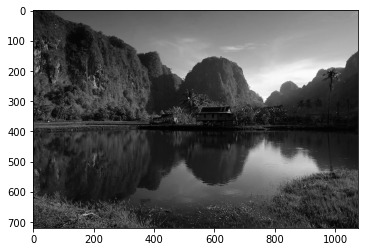

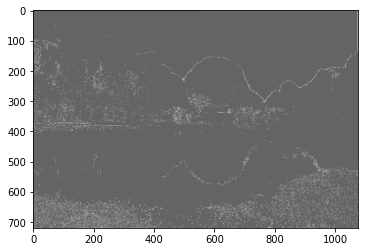

In [91]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)
# print("img_O_cpu: ", img_O_cpu)
# print("img_R_cpu: ", img_R_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
//  float fGris = 0.0;

  int matHPF[3][3] = {{-1, -1, -1}, {-1, 9, -1}, {-1, -1, -1}};
  int umbral = 400;

  int matAuxRojo[3][3] = {{0,0,0}, {0,0,0}, {0,0,0}};
  int matAuxVerde[3][3] = {{0,0,0}, {0,0,0}, {0,0,0}};
  int matAuxAzul[3][3] = {{0,0,0}, {0,0,0}, {0,0,0}};

  int sumaRojo = 0;
  int sumaVerde = 0;
  int sumaAzul = 0;

  int i, j, auxI, auxJ;


  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {

    auxI = 0;
    auxJ = 0;

    for(i = idx - 1; i <= idx + 1 && i < ancho; i++)
    {

        if(i < 0)
        {
          i++;
          auxI++;
        }
          

      for(j = idy - 1; j <= idy + 1 && j < alto; j++)
      {
        if(j < 0)
        {
          j++;
          auxJ++;
        }
        

        matAuxRojo[auxI][auxJ] = matHPF[auxI][auxJ] * img_O[(i + (j*ancho)) * 3];
        matAuxVerde[auxI][auxJ] = matHPF[auxI][auxJ] * img_O[((i +(j*ancho))*3)+1];
        matAuxAzul[auxI][auxJ] = matHPF[auxI][auxJ] * img_O[((i +(j*ancho))*3)+2];
        auxJ++;
      }
      auxI++;
      auxJ = 0;
    }

    for(i = 0; i < 3; i++)
    {
      for(j = 0; j < 3; j++)
      {
        sumaRojo += matAuxRojo[i][j];
        sumaVerde += matAuxVerde[i][j];
        sumaAzul += matAuxAzul[i][j];
      }
    }

    if(sumaRojo > umbral)
    img_R[(idx+(idy*ancho))*3  ] = sumaRojo;
    else
    img_R[(idx+(idy*ancho))*3  ] = 100;

    if(sumaVerde > umbral)
    img_R[(idx+(idy*ancho))*3+1] = sumaVerde;
    else
    img_R[(idx+(idy*ancho))*3+1] = 100;

    if(sumaAzul > umbral)
    img_R[(idx+(idy*ancho))*3+2] = sumaAzul;
    else
    img_R[(idx+(idy*ancho))*3+2] = 100;
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

cuda.Context.synchronize();

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )








<font size="+2"> 5 - Conclusiones y Bibliografía </font>

- Bibliografía ejemplo HPF CPU: [High Pass Filter CPU](https://stackoverflow.com/questions/6094957/high-pass-filter-for-image-processing-in-python-by-using-scipy-numpy)

